# Why Fake News is a Problem?
**Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence and suicides.**

# Loading the necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install libraries/module that are not yet installed in my system
!pip install wordcloud
!pip install keras
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Import the dataset

In [ ]:
true = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/True.xlsx')
fake = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Fake.xlsx')

# Exploratory Data Analysis

In [ ]:
true.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [ ]:
fake.head()

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [ ]:
true['category'] = 1
fake['category'] = 0

In [ ]:
df = pd.concat([true,fake]) #Merging the 2 datasets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


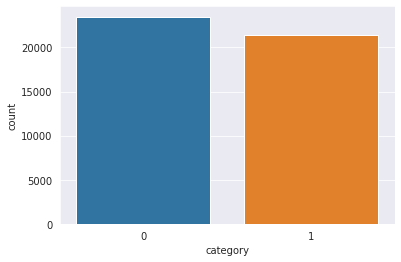

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

**We can see that the dataset is balanced**

In [ ]:
df.head()

title  ... category
0  As U.S. budget fight looms, Republicans flip t...  ...        1
1  U.S. military to accept transgender recruits o...  ...        1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...        1
3  FBI Russia probe helped by Australian diplomat...  ...        1
4  Trump wants Postal Service to charge 'much mor...  ...        1

[5 rows x 5 columns]

In [ ]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
len(df) # Checking the length of the dataframe

44898

In [ ]:
df.subject.value_counts() # Get the counts of each category of the subject of the text

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

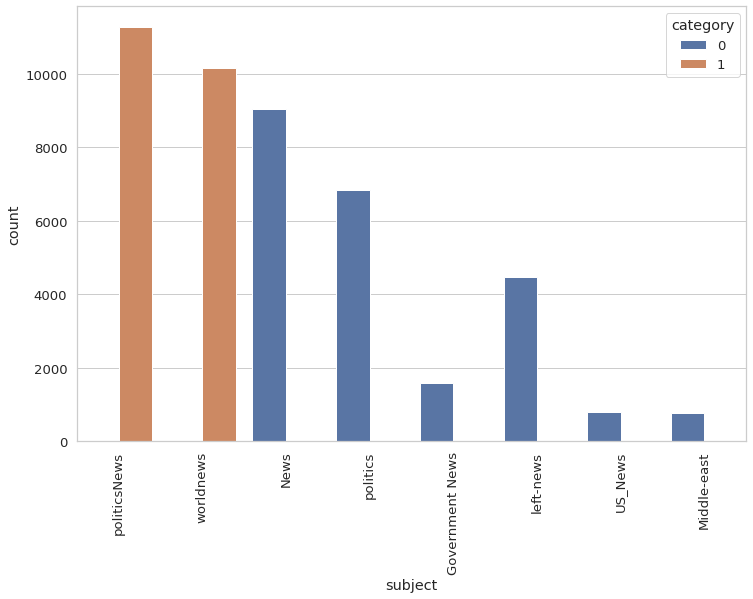

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**Since the topics in subject column are different for both categories, it is not a good predictor on detecting fake news. Hence, we have to exclude it from final text column.**


1.   Merge all text data into 1 column for easier analysis
2.   Remove subject column due to the reason stated in above cell.
3.   Remove date column which is not a good predictor on classifying real or fake news.



In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**Stopwords**

**Stopwords are words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [ ]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation) # stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(list(stop)) # print all words currently in our stopwords list

['but', 'now', 'wouldn', '*', 'hadn', 'ours', '&', 'both', 'myself', '_', 'her', "isn't", 'after', 'because', 'very', "mightn't", 'once', 'by', '-', 'our', 'with', 'such', 'into', 'off', 'him', 'did', 'that', "should've", 'own', 'm', 'haven', '!', ':', 'up', '|', '"', 'aren', 'no', '>', 'does', 'his', 'for', "mustn't", 'shan', 'an', "you've", 'a', 'when', 'against', 'there', 'they', 'of', 'some', "aren't", 'those', "it's", 'y', 'while', 'down', '}', 'can', 'what', 'himself', 'needn', 'between', 'too', 'whom', 'each', 'hasn', 'just', 'through', 'their', ')', "that'll", "'", '<', 'ma', 'my', 'the', 'as', 'ain', '=', 'i', 'before', ',', 'under', '[', 'having', 'more', 'yourself', 'over', 'only', "you're", 'couldn', 'these', '/', 'shouldn', 'them', 'in', '$', 'below', 'during', 'if', 'same', 'until', 'have', 'were', "haven't", "hadn't", 'doesn', 'other', ']', 'most', 'she', 'which', 'to', 'further', 'any', 'll', 'been', 'at', 'theirs', 'then', 'he', 'itself', 'how', 'has', '^', 'be', "you'

#Word Preprocessing + Further EDA

In [ ]:
# Remove HTML tag
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Remove URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)
# Remove the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Remove the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text
#Apply function on the text column
df['text']=df['text'].apply(denoise_text)

In [ ]:
df.head()

text  category
0  WASHINGTON (Reuters) head conservative Republi...         1
1  WASHINGTON (Reuters) Transgender people allowe...         1
2  WASHINGTON (Reuters) special counsel investiga...         1
3  WASHINGTON (Reuters) Trump campaign adviser Ge...         1
4  SEATTLE/WASHINGTON (Reuters) President Donald ...         1

**Wordcloud for Real Text (Category - 1)**

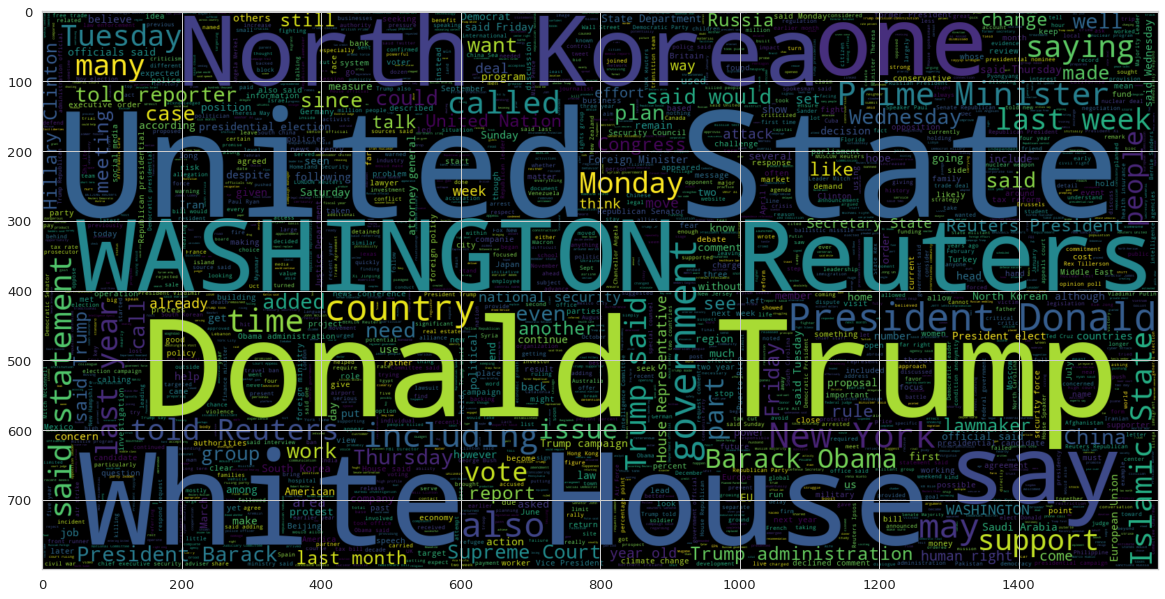

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear') # https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html

**Wordcloud for Real Text (Category - 0)**

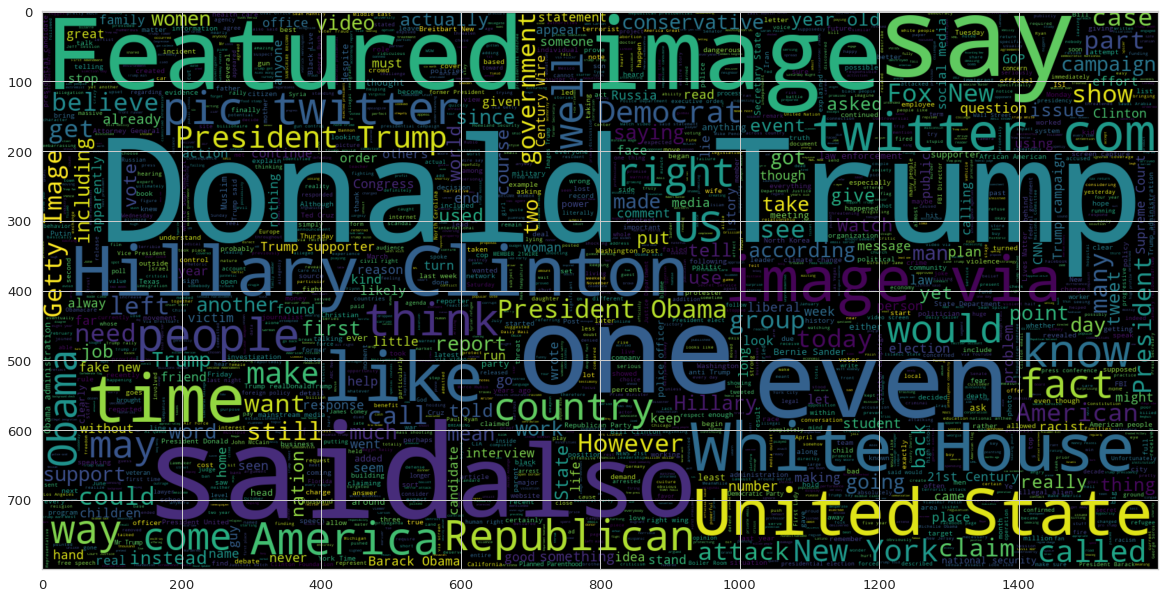

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'hamming')

**Number of characters in texts**

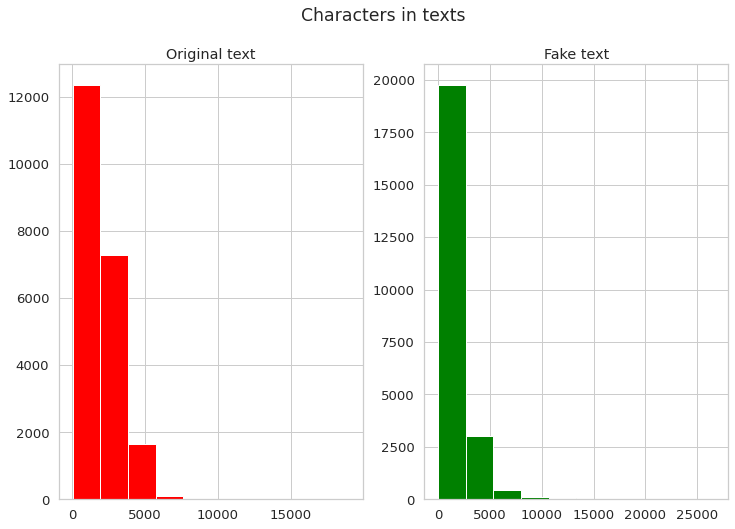

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts') # Add a centered title on the figures
plt.show()

**The distribution of both seems to be a bit different. 2500 characters in text is more common in original text category while around 5000 characters in text is more common in fake text category.**

**Number of words in each text**

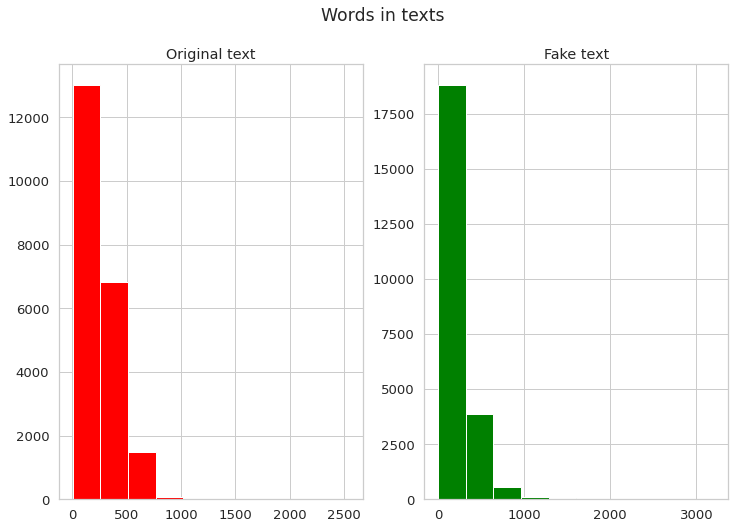

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

In [ ]:
# Get the corpus list - list of all words after word preprocessing (including all duplicates)
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [ ]:
# Top 10 most common words in the corpus
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
print(dict(most_common))

{'Trump': 111480, 'said': 93110, 'would': 54597, 'U.S.': 50398, 'President': 33167, 'people': 33095, 'also': 30268, 'one': 29317, 'Donald': 27796, 'said.': 26191}


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Get the top n word/words with highest frequencies
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

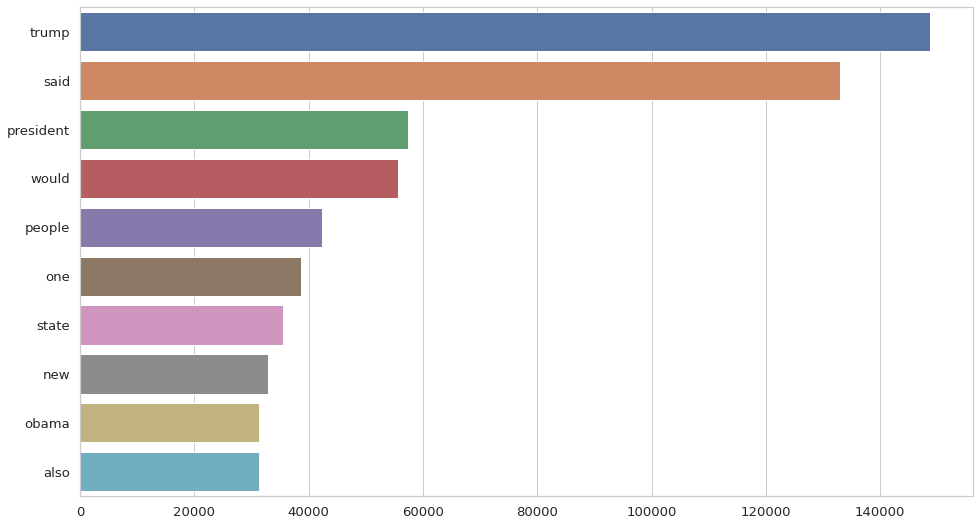

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

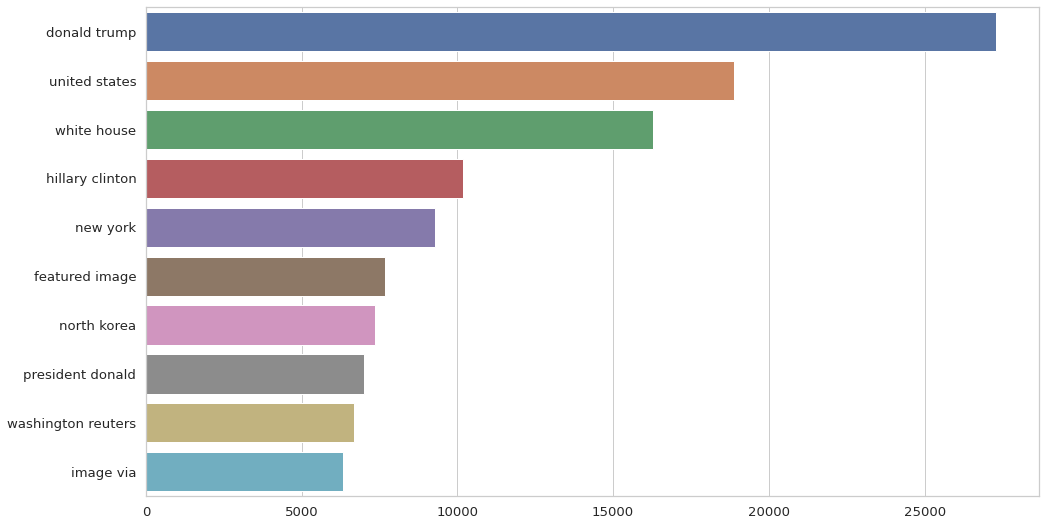

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

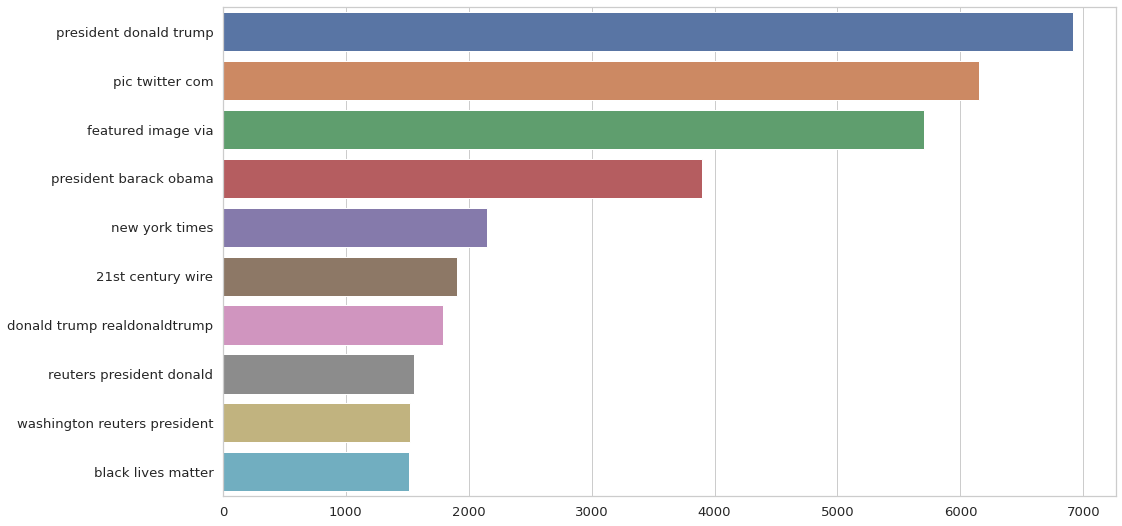

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Splitting the data into 2 parts - training and testing data**

In [ ]:
# Shuffle=True means we will shuffle the dataset before splliting 
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category, test_size=0.2, shuffle=True, random_state = 0)

In [ ]:
x_train

16971    Thank God America people like Ted Cruz Senate,...
1719     Donald Trump fit president. nation knows this....
2804     Donald Trump writing Executive Orders ban Musl...
8837     WASHINGTON (Reuters) Democrat Bernie Sanders e...
15902    WASHINGTON (Reuters) rare high-level defector ...
                               ...                        
8986     Paul Krugman, admission, drooling release IRS ...
21243    GUATEMALA CITY (Reuters) Guatemala top court T...
21196    PLAN ELECTRICITY RATES WOULD NECESSARILY SKYRO...
22150    21st Century Wire says Washington Russian witc...
2732     WINNIPEG, Manitoba (Reuters) Former U.S. Presi...
Name: text, Length: 35918, dtype: object

In [ ]:
x_test

13888    Democrats want spend whopping $2 billion zika ...
7763     Republican presidential candidate Texas Senato...
8388     National Rifle Association tells us need ensur...
16820    case live Midwest, might noticed fight continu...
5099     DUBAI (Reuters) Etihad Airways advising passen...
                               ...                        
16364    FBI files reveal missing email boxes Clinton c...
2275     following statements posted verified Twitter a...
19324    DUBLIN (Reuters) Ireland foreign minister Frid...
1178     WASHINGTON (Reuters) U.S. House Representative...
13055    month ago, people started noticing large black...
Name: text, Length: 8980, dtype: object

In [ ]:
max_features = 10000
maxlen = 300

1. Machine doesn’t understand text so we need to convert the text in machine readable language and that is nothing but the numbers. To convert text into numbers we have a class in keras called Tokenizer.
2. text_to_sequence is nothing but it converts the generated tokens in the sequence as per the sentence that we had feed to the tokenizer class.
3. We need to pad each sentence as the neural network expects input sequence of the same length. Specify maxlen to set the length of the sequences
By default, sequences are padded or truncated from the start of the sequence.

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [ ]:
tokenizer.word_index.items()

dict_items([('trump', 1), ('said', 2), ('u', 3), ('s', 4), ('president', 5), ('would', 6), ('people', 7), ('”', 8), ('one', 9), ('state', 10), ('new', 11), ('also', 12), ('house', 13), ('reuters', 14), ('donald', 15), ('obama', 16), ('clinton', 17), ('government', 18), ('states', 19), ('republican', 20), ('year', 21), ('could', 22), ('white', 23), ('united', 24), ('told', 25), ('like', 26), ('campaign', 27), ('election', 28), ('two', 29), ('time', 30), ('news', 31), ('last', 32), ('party', 33), ('first', 34), ('washington', 35), ('the', 36), ('hillary', 37), ('former', 38), ('even', 39), ('us', 40), ('country', 41), ('years', 42), ('many', 43), ('media', 44), ('american', 45), ('security', 46), ('it', 47), ('law', 48), ('may', 49), ('say', 50), ('police', 51), ('made', 52), ('national', 53), ('political', 54), ('court', 55), ('get', 56), ('right', 57), ('make', 58), ('republicans', 59), ('since', 60), ('twitter', 61), ('russia', 62), ('going', 63), ('back', 64), ('bill', 65), ('percent

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(x_train)
# Pad the list with zeros until the length is 300
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_train[0][:3] # 1709 is the index for 'thank', 1124 is the index for 'god', 78 is the index for 'america'

[1709, 1124, 78]

In [ ]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 1709, 1124,
         78,    7,   26,  799,  292,   72,  888, 2483,  411, 1050,   46,
        280,  264,   22,   56, 1699,  207, 7315, 2692, 5177, 2483,   78,
        226,  592,  626, 1179,  237,  721, 2641, 57

In [ ]:
# Apply the same tokenization and padding to x_test
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# GloVe

**Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010**

In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
# For example, examine the global vectors for 'tweets'
embeddings_index['tweets'] #100 dimensions

array([ 8.0965e-01,  3.8748e-01, -2.8456e-01, -1.8585e-01,  5.3259e-01,
        3.0202e-02,  3.4154e-01,  3.0150e-01, -3.3122e-01,  4.8006e-01,
       -5.5430e-02,  6.3861e-02, -3.8095e+00, -2.5469e-01, -9.3760e-01,
        3.9238e-01,  3.4647e-01,  3.0318e-02, -2.7251e-01,  2.4214e-02,
       -2.5412e-01, -1.4075e-01, -1.2836e+00, -3.5448e-01, -4.9216e-01,
       -2.1957e+00, -6.1950e-01, -6.9797e-01,  1.3171e-01, -2.1400e-01,
       -4.3359e-01,  5.0234e-01, -5.0239e-01, -7.0557e-01,  1.1628e-01,
       -4.1339e-01,  6.0546e-02, -1.4611e-01, -2.6962e-01, -1.1968e+00,
       -8.3444e-01, -2.4194e-01,  9.2794e-02,  2.2458e-01, -4.1520e-01,
       -6.0525e-01,  4.7790e-01,  2.8090e-01, -8.3348e-01,  7.9158e-02,
       -8.7105e-02,  1.9451e-01,  5.0340e-02, -2.9742e-01,  5.2881e-01,
        2.0822e-01, -1.0031e+00,  1.2737e-01, -8.1068e-02,  2.8949e-03,
        3.4129e-01, -6.3634e-01,  4.5078e-01,  6.5871e-01,  9.5763e-02,
        8.9710e-01,  4.3940e-01,  1.5053e+00, -2.9487e-01,  4.82

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1] #100

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)) #10000
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    # if the word is present in the glove vectors, change the embedidng
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
all_embs.shape

(1193514, 100)

In [ ]:
embedding_matrix.shape

(10000, 100)

**Some Model Parameters**

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# Model Building

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
141/141 [==============================] - 454s 3s/step - loss: 0.3207 - accuracy: 0.8504 - val_loss: 0.1531 - val_accuracy: 0.9501
Epoch 2/10
141/141 [==============================] - 441s 3s/step - loss: 0.0791 - accuracy: 0.9707 - val_loss: 0.0159 - val_accuracy: 0.9944
Epoch 3/10
141/141 [==============================] - 440s 3s/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0105 - val_accuracy: 0.9969
Epoch 4/10
141/141 [==============================] - 438s 3s/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0110 - val_accuracy: 0.9962
Epoch 5/10
141/141 [==============================] - 440s 3s/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.0145 - val_accuracy: 0.9950

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/10
141/141 [==============================] - 443s 3s/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0106 - val_accuracy: 0.9972
Epoch 7/10
141/141 [==============================] - 443s 3s/

# Model Evaluation

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1123/1123 [==============================] - 229s 204ms/step - loss: 6.2133e-04 - accuracy: 0.9999
Accuracy of the model on Training Data is -  99.99443292617798 %
281/281 [==============================] - 57s 204ms/step - loss: 0.0100 - accuracy: 0.9979
Accuracy of the model on Testing Data is -  99.7884213924408 %


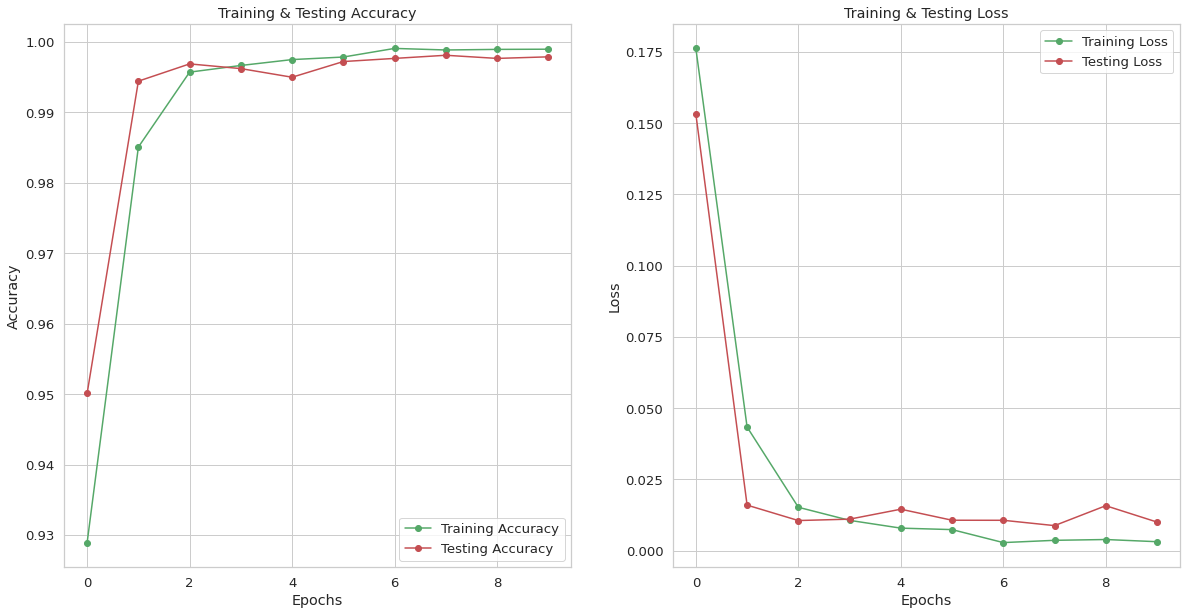

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4670
    Not Fake       1.00      1.00      1.00      4310

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[4667,    3],
       [  16, 4294]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(63.5, 0.5, 'Actual')

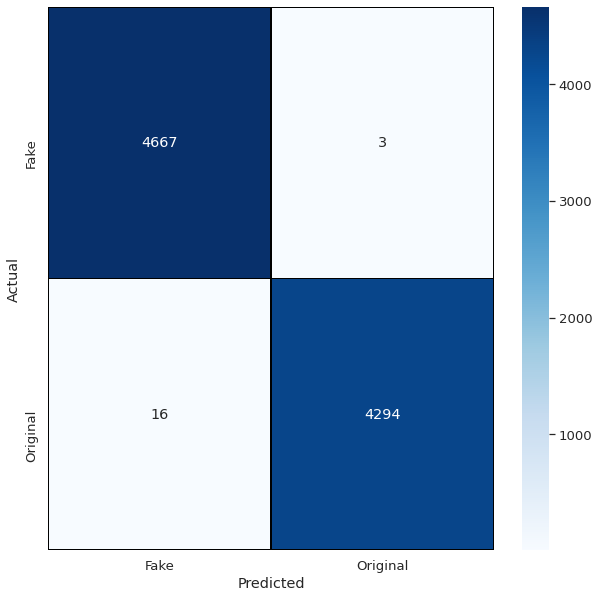

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")